## Imports

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

## Loading Files

In [2]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [3]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Take first 8000 training samples
X_train = X_train[:8000]
y_train = y_train[:8000]

print(X_train.shape, X_val.shape)

(8000, 6, 28) (4000, 6, 28)


In [4]:
# Checking the label distribution of the train set
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
total = counts_train.sum()

print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels_train, counts_train):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

Label     Count     Percentage
------------------------------
0         3676      45.95%
1         1036      12.95%
2         3288      41.10%

Total samples: 8000


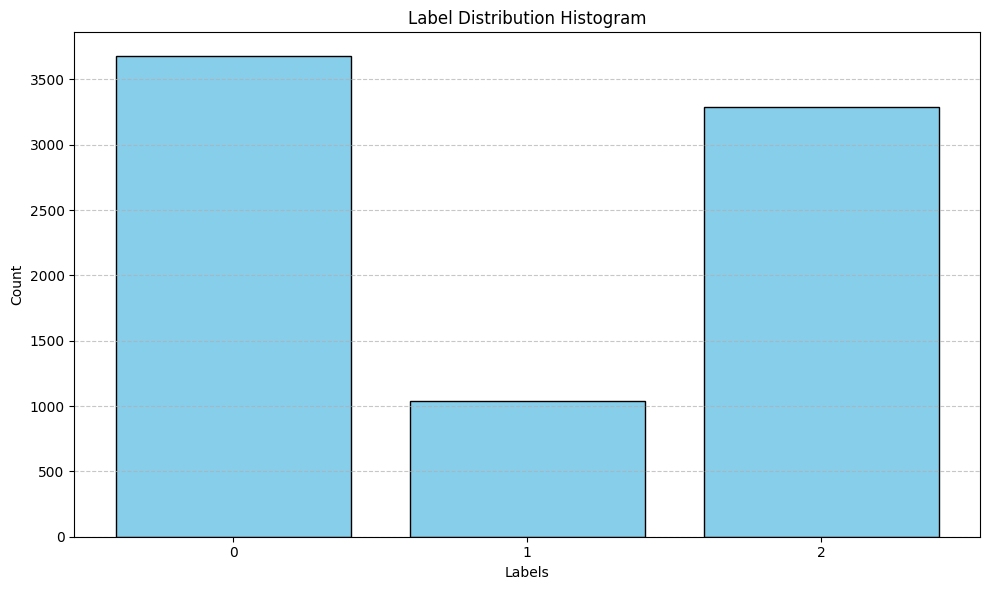

In [5]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels_train.astype(str), counts_train, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset Class

In [6]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [7]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Model

In [75]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int, dropout_p=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )
 
 
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [76]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn_dropout()
backbone.to(device)

fc = FC_dropout(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [77]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

## Evaluation Function

In [78]:
def mc_dropout_eval(backbone, fc, dataloader, T=20):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            all_labels.append(y.cpu())

            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    return acc, f1_macro, f1_per_class

## Acquisition Function

In [79]:
# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc='MC Dropout Simulations (PredEntropy)'):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                logits.append(F.softmax(out, dim=1).cpu())
            probs = torch.cat(logits, dim=0)
            mc_probs.append(probs)

    mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BALD (Bayesian AL by Disagreement) ============= 
def bald_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc="MC Dropout Simulations (BALD)"):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                probs = F.softmax(out, dim=1).cpu()
                logits.append(probs)
            mc_probs.append(torch.cat(logits, dim=0))

    mc_probs = torch.stack(mc_probs)  # [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # [N, C]

    # Predictive Entropy
    H = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # [N]

    # Expected Entropy
    E_H = -torch.sum(mc_probs * torch.log(mc_probs + 1e-8), dim=2).mean(dim=0)  # [N]

    # BALD = H - E_H
    bald_score = H - E_H
    topk = torch.topk(bald_score, k=k).indices
    return [indices[i.item()] for i in topk]



# ============= Variation Ratios ============= 
def variation_ratio_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    preds = []

    with torch.no_grad():
        for _ in tqdm(range(sim), desc="MC Dropout Simulations (VarRatio)"):
            logits = []
            for i in range(0, len(X_pool), 32):
                x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                pred = torch.argmax(out, dim=1).cpu()
                logits.append(pred)
            preds.append(torch.cat(logits, dim=0))

    preds = torch.stack(preds)  # [T, N]
    mode_preds = torch.mode(preds, dim=0)[0]  # [N]
    agreement = (preds == mode_preds.unsqueeze(0)).sum(dim=0)  # [N]
    variation_ratio = 1 - agreement.float() / sim

    topk = torch.topk(variation_ratio, k=k).indices
    return [indices[i.item()] for i in topk]

In [80]:
sampling_strategies = {
    "predictive_entropy": predictive_entropy_sampling,
    "bald": bald_sampling,
    "variation_ratio": variation_ratio_sampling,
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_avg_f1": [],
        "val_f1s": []
    }

## Training Loop

In [81]:
all_labels = np.array(y_train)  # shape: (num_samples, H, W) if segmentation

num_classes = 3  # e.g., 5 for 5 classes

# Flatten labels and count occurrences
flattened = all_labels.flatten()
flattened = flattened[flattened >= 0]
class_counts = np.bincount(flattened, minlength=num_classes)
total_pixels = class_counts.sum()

# Inverse frequency (optionally normalize)
class_weights = total_pixels / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights = torch.log(1 + class_weights)

print(class_weights)

tensor([0.5455, 1.2737, 0.5939], device='cuda:0')


In [82]:
def train(backbone, fc, train_loader, device, epochs=5):
    backbone.train()
    fc.train()

    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=1e-4)
    train_accuracies = []
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt, weight=class_weights)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total += yt.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        
        if (epoch+1)%5 == 0:    
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}%")

    return train_accuracies, train_losses

## AL Pipeling Loop

In [83]:
num_rounds = 10
query_size = 400
sim = 30
epochs = 50

# Calculate total and effective samples
total_samples = num_rounds * query_size
effective_samples = query_size * (num_rounds * (num_rounds + 1)) // 2  # Sum of 1+2+...+num_rounds

# Nicely formatted print
print("=" * 50)
print(" Active Learning Configuration Summary")
print("=" * 50)
print(f"Simulations (sim):          {sim}")
print(f"Number of Rounds:           {num_rounds}")
print(f"Query Size per Round:       {query_size}")
print(f"Number of epochs:           {epochs}")
print(f"Total Labeled Samples:      {total_samples}")
print(f"Effective Samples (Total):  {effective_samples}")
print("=" * 50)

 Active Learning Configuration Summary
Simulations (sim):          30
Number of Rounds:           10
Query Size per Round:       400
Number of epochs:           50
Total Labeled Samples:      4000
Effective Samples (Total):  22000


In [84]:
for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    for round_num in range(1, num_rounds + 1):
        print(f"\n--- Round {round_num} [{name}] ---")
    
        # Cold start: Re-initialize model at every round
        # backbone = cnn_dropout().to(device)
        # fc = FC_dropout(1024).to(device)
        # backbone.load_state_dict(backbone_state)
        # fc.load_state_dict(fc_state)
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model_backbone=backbone,
            model_fc=fc,
            k=query_size,
            device=device,
            unlabeled_pool=unlabeled_pool,
            sim = sim
        )
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
        # 4. Train + Evaluate
        train_acc, train_loss = train(backbone, fc, train_loader, device, epochs=epochs)
        val_f1s, val_acc, val_avg_f1 = mc_dropout_eval(backbone, fc, val_dataloader, sim)
        
        print("Per-class F1 scores:", val_f1s)
        print(f"Overall Accuracy: {val_acc * 100:.2f}%")
        # print(f"Average F1 Score: {val_avg_f1:.4f}")
    
        # 5. Update history
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["train_accuracy"].append(train_acc)
        history["train_loss"].append(train_loss)
        history["val_accuracy"].append(val_acc)
        history["val_avg_f1"].append(val_avg_f1)
        history["val_f1s"].append(val_f1s.tolist())


 Running strategy: PREDICTIVE_ENTROPY 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 8000

--- Round 1 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 7600
Epoch 5/50, Loss: 1.9158, Train Acc: 49.50%
Epoch 10/50, Loss: 1.3268, Train Acc: 62.00%
Epoch 15/50, Loss: 1.2728, Train Acc: 69.25%
Epoch 20/50, Loss: 0.8247, Train Acc: 76.00%
Epoch 25/50, Loss: 0.9415, Train Acc: 71.25%
Epoch 30/50, Loss: 0.8270, Train Acc: 74.75%
Epoch 35/50, Loss: 0.6501, Train Acc: 75.75%
Epoch 40/50, Loss: 0.7727, Train Acc: 76.25%
Epoch 45/50, Loss: 0.5621, Train Acc: 77.75%
Epoch 50/50, Loss: 0.5720, Train Acc: 78.50%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.57it/s]


Per-class F1 scores: 0.73575
Overall Accuracy: 70.31%

--- Round 2 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 7200
Epoch 5/50, Loss: 0.7329, Train Acc: 72.25%
Epoch 10/50, Loss: 0.6748, Train Acc: 73.00%
Epoch 15/50, Loss: 0.6210, Train Acc: 75.12%
Epoch 20/50, Loss: 0.5637, Train Acc: 78.38%
Epoch 25/50, Loss: 0.4932, Train Acc: 80.38%
Epoch 30/50, Loss: 0.5038, Train Acc: 77.75%
Epoch 35/50, Loss: 0.4547, Train Acc: 81.00%
Epoch 40/50, Loss: 0.4825, Train Acc: 82.25%
Epoch 45/50, Loss: 0.4395, Train Acc: 80.62%
Epoch 50/50, Loss: 0.4350, Train Acc: 82.62%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.8145
Overall Accuracy: 80.56%

--- Round 3 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Length of Labeled Pool: 1200
Length of Unlabeled Pool: 6800
Epoch 5/50, Loss: 0.6260, Train Acc: 71.08%
Epoch 10/50, Loss: 0.6310, Train Acc: 72.25%
Epoch 15/50, Loss: 0.5722, Train Acc: 74.33%
Epoch 20/50, Loss: 0.6046, Train Acc: 74.67%
Epoch 25/50, Loss: 0.5740, Train Acc: 75.17%
Epoch 30/50, Loss: 0.5812, Train Acc: 74.83%
Epoch 35/50, Loss: 0.5300, Train Acc: 76.92%
Epoch 40/50, Loss: 0.5207, Train Acc: 76.83%
Epoch 45/50, Loss: 0.5322, Train Acc: 76.67%
Epoch 50/50, Loss: 0.5067, Train Acc: 77.25%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]


Per-class F1 scores: 0.87425
Overall Accuracy: 87.50%

--- Round 4 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Length of Labeled Pool: 1600
Length of Unlabeled Pool: 6400
Epoch 5/50, Loss: 0.6298, Train Acc: 72.44%
Epoch 10/50, Loss: 0.6010, Train Acc: 71.38%
Epoch 15/50, Loss: 0.5813, Train Acc: 73.06%
Epoch 20/50, Loss: 0.5989, Train Acc: 73.56%
Epoch 25/50, Loss: 0.6089, Train Acc: 72.19%
Epoch 30/50, Loss: 0.5804, Train Acc: 74.25%
Epoch 35/50, Loss: 0.5626, Train Acc: 74.19%
Epoch 40/50, Loss: 0.5378, Train Acc: 74.75%
Epoch 45/50, Loss: 0.5569, Train Acc: 74.31%
Epoch 50/50, Loss: 0.5389, Train Acc: 75.44%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.50it/s]


Per-class F1 scores: 0.878
Overall Accuracy: 87.59%

--- Round 5 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Length of Labeled Pool: 2000
Length of Unlabeled Pool: 6000
Epoch 5/50, Loss: 0.6216, Train Acc: 72.60%
Epoch 10/50, Loss: 0.6069, Train Acc: 71.80%
Epoch 15/50, Loss: 0.5985, Train Acc: 73.10%
Epoch 20/50, Loss: 0.5767, Train Acc: 73.55%
Epoch 25/50, Loss: 0.5923, Train Acc: 73.45%
Epoch 30/50, Loss: 0.5793, Train Acc: 74.00%
Epoch 35/50, Loss: 0.5592, Train Acc: 74.15%
Epoch 40/50, Loss: 0.5419, Train Acc: 76.15%
Epoch 45/50, Loss: 0.5477, Train Acc: 74.90%
Epoch 50/50, Loss: 0.5458, Train Acc: 76.25%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]


Per-class F1 scores: 0.8845
Overall Accuracy: 88.28%

--- Round 6 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Length of Labeled Pool: 2400
Length of Unlabeled Pool: 5600
Epoch 5/50, Loss: 0.5542, Train Acc: 74.92%
Epoch 10/50, Loss: 0.5696, Train Acc: 72.62%
Epoch 15/50, Loss: 0.5532, Train Acc: 74.67%
Epoch 20/50, Loss: 0.5525, Train Acc: 75.46%
Epoch 25/50, Loss: 0.5579, Train Acc: 74.75%
Epoch 30/50, Loss: 0.5268, Train Acc: 74.88%
Epoch 35/50, Loss: 0.5335, Train Acc: 75.75%
Epoch 40/50, Loss: 0.5399, Train Acc: 76.21%
Epoch 45/50, Loss: 0.5177, Train Acc: 76.38%
Epoch 50/50, Loss: 0.5239, Train Acc: 75.96%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.89125
Overall Accuracy: 88.81%

--- Round 7 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


Length of Labeled Pool: 2800
Length of Unlabeled Pool: 5200
Epoch 5/50, Loss: 0.5326, Train Acc: 74.54%
Epoch 10/50, Loss: 0.5037, Train Acc: 76.86%
Epoch 15/50, Loss: 0.5212, Train Acc: 75.82%
Epoch 20/50, Loss: 0.5100, Train Acc: 76.18%
Epoch 25/50, Loss: 0.5029, Train Acc: 76.54%
Epoch 30/50, Loss: 0.5018, Train Acc: 78.00%
Epoch 35/50, Loss: 0.4890, Train Acc: 78.32%
Epoch 40/50, Loss: 0.4771, Train Acc: 78.25%
Epoch 45/50, Loss: 0.4653, Train Acc: 78.64%
Epoch 50/50, Loss: 0.4807, Train Acc: 78.68%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.56it/s]


Per-class F1 scores: 0.89375
Overall Accuracy: 89.32%

--- Round 8 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:10<00:00,  3.00it/s]


Length of Labeled Pool: 3200
Length of Unlabeled Pool: 4800
Epoch 5/50, Loss: 0.4721, Train Acc: 79.25%
Epoch 10/50, Loss: 0.4847, Train Acc: 78.62%
Epoch 15/50, Loss: 0.4632, Train Acc: 79.47%
Epoch 20/50, Loss: 0.4590, Train Acc: 79.94%
Epoch 25/50, Loss: 0.4734, Train Acc: 78.44%
Epoch 30/50, Loss: 0.4654, Train Acc: 79.31%
Epoch 35/50, Loss: 0.4517, Train Acc: 80.03%
Epoch 40/50, Loss: 0.4423, Train Acc: 79.81%
Epoch 45/50, Loss: 0.4459, Train Acc: 81.56%
Epoch 50/50, Loss: 0.4482, Train Acc: 79.75%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.51it/s]


Per-class F1 scores: 0.894
Overall Accuracy: 89.17%

--- Round 9 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Length of Labeled Pool: 3600
Length of Unlabeled Pool: 4400
Epoch 5/50, Loss: 0.4392, Train Acc: 80.31%
Epoch 10/50, Loss: 0.4561, Train Acc: 79.97%
Epoch 15/50, Loss: 0.4404, Train Acc: 80.81%
Epoch 20/50, Loss: 0.4225, Train Acc: 81.31%
Epoch 25/50, Loss: 0.4152, Train Acc: 82.03%
Epoch 30/50, Loss: 0.4039, Train Acc: 81.56%
Epoch 35/50, Loss: 0.4090, Train Acc: 82.44%
Epoch 40/50, Loss: 0.3966, Train Acc: 82.28%
Epoch 45/50, Loss: 0.4041, Train Acc: 81.75%
Epoch 50/50, Loss: 0.4182, Train Acc: 82.19%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.54it/s]


Per-class F1 scores: 0.89425
Overall Accuracy: 89.24%

--- Round 10 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


Length of Labeled Pool: 4000
Length of Unlabeled Pool: 4000
Epoch 5/50, Loss: 0.3935, Train Acc: 83.10%
Epoch 10/50, Loss: 0.4047, Train Acc: 83.43%
Epoch 15/50, Loss: 0.3755, Train Acc: 83.80%
Epoch 20/50, Loss: 0.3941, Train Acc: 83.47%
Epoch 25/50, Loss: 0.3761, Train Acc: 84.65%
Epoch 30/50, Loss: 0.3735, Train Acc: 84.70%
Epoch 35/50, Loss: 0.3721, Train Acc: 83.97%
Epoch 40/50, Loss: 0.3766, Train Acc: 84.05%
Epoch 45/50, Loss: 0.3649, Train Acc: 84.85%
Epoch 50/50, Loss: 0.3691, Train Acc: 84.23%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.51it/s]


Per-class F1 scores: 0.891
Overall Accuracy: 89.05%

 Running strategy: BALD 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 8000

--- Round 1 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 7600
Epoch 5/50, Loss: 0.5436, Train Acc: 76.25%
Epoch 10/50, Loss: 0.6117, Train Acc: 72.50%
Epoch 15/50, Loss: 0.5599, Train Acc: 73.75%
Epoch 20/50, Loss: 0.5851, Train Acc: 74.50%
Epoch 25/50, Loss: 0.4732, Train Acc: 78.25%
Epoch 30/50, Loss: 0.4123, Train Acc: 84.00%
Epoch 35/50, Loss: 0.3938, Train Acc: 83.25%
Epoch 40/50, Loss: 0.4379, Train Acc: 81.75%
Epoch 45/50, Loss: 0.4864, Train Acc: 80.25%
Epoch 50/50, Loss: 0.4536, Train Acc: 82.00%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.57it/s]


Per-class F1 scores: 0.88275
Overall Accuracy: 88.16%

--- Round 2 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 7200
Epoch 5/50, Loss: 0.3866, Train Acc: 81.75%
Epoch 10/50, Loss: 0.3525, Train Acc: 83.25%
Epoch 15/50, Loss: 0.3767, Train Acc: 82.38%
Epoch 20/50, Loss: 0.3471, Train Acc: 83.88%
Epoch 25/50, Loss: 0.3557, Train Acc: 84.62%
Epoch 30/50, Loss: 0.3325, Train Acc: 82.62%
Epoch 35/50, Loss: 0.3321, Train Acc: 84.62%
Epoch 40/50, Loss: 0.3254, Train Acc: 85.25%
Epoch 45/50, Loss: 0.3041, Train Acc: 85.50%
Epoch 50/50, Loss: 0.2980, Train Acc: 85.62%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.8945
Overall Accuracy: 89.38%

--- Round 3 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Length of Labeled Pool: 1200
Length of Unlabeled Pool: 6800
Epoch 5/50, Loss: 0.4231, Train Acc: 79.50%
Epoch 10/50, Loss: 0.4316, Train Acc: 79.08%
Epoch 15/50, Loss: 0.3911, Train Acc: 81.00%
Epoch 20/50, Loss: 0.3848, Train Acc: 83.33%
Epoch 25/50, Loss: 0.3641, Train Acc: 83.58%
Epoch 30/50, Loss: 0.3749, Train Acc: 82.42%
Epoch 35/50, Loss: 0.3664, Train Acc: 82.83%
Epoch 40/50, Loss: 0.3572, Train Acc: 84.08%
Epoch 45/50, Loss: 0.3511, Train Acc: 83.67%
Epoch 50/50, Loss: 0.3689, Train Acc: 81.67%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.56it/s]


Per-class F1 scores: 0.89325
Overall Accuracy: 89.20%

--- Round 4 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:13<00:00,  2.30it/s]


Length of Labeled Pool: 1600
Length of Unlabeled Pool: 6400
Epoch 5/50, Loss: 0.3962, Train Acc: 80.50%
Epoch 10/50, Loss: 0.3909, Train Acc: 81.12%
Epoch 15/50, Loss: 0.3758, Train Acc: 81.94%
Epoch 20/50, Loss: 0.3646, Train Acc: 81.81%
Epoch 25/50, Loss: 0.3641, Train Acc: 81.25%
Epoch 30/50, Loss: 0.3651, Train Acc: 83.38%
Epoch 35/50, Loss: 0.3419, Train Acc: 85.00%
Epoch 40/50, Loss: 0.3584, Train Acc: 84.06%
Epoch 45/50, Loss: 0.3536, Train Acc: 83.50%
Epoch 50/50, Loss: 0.3653, Train Acc: 82.12%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.89825
Overall Accuracy: 89.57%

--- Round 5 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Length of Labeled Pool: 2000
Length of Unlabeled Pool: 6000
Epoch 5/50, Loss: 0.3575, Train Acc: 81.95%
Epoch 10/50, Loss: 0.3486, Train Acc: 83.45%
Epoch 15/50, Loss: 0.3892, Train Acc: 81.75%
Epoch 20/50, Loss: 0.3401, Train Acc: 83.60%
Epoch 25/50, Loss: 0.3756, Train Acc: 82.00%
Epoch 30/50, Loss: 0.3524, Train Acc: 83.60%
Epoch 35/50, Loss: 0.3716, Train Acc: 82.00%
Epoch 40/50, Loss: 0.3472, Train Acc: 84.45%
Epoch 45/50, Loss: 0.3425, Train Acc: 83.85%
Epoch 50/50, Loss: 0.3321, Train Acc: 84.60%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]


Per-class F1 scores: 0.89725
Overall Accuracy: 89.60%

--- Round 6 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Length of Labeled Pool: 2400
Length of Unlabeled Pool: 5600
Epoch 5/50, Loss: 0.3419, Train Acc: 84.83%
Epoch 10/50, Loss: 0.3484, Train Acc: 84.29%
Epoch 15/50, Loss: 0.3468, Train Acc: 84.21%
Epoch 20/50, Loss: 0.3454, Train Acc: 84.04%
Epoch 25/50, Loss: 0.3406, Train Acc: 84.79%
Epoch 30/50, Loss: 0.3322, Train Acc: 84.75%
Epoch 35/50, Loss: 0.3400, Train Acc: 84.33%
Epoch 40/50, Loss: 0.3461, Train Acc: 83.08%
Epoch 45/50, Loss: 0.3410, Train Acc: 84.58%
Epoch 50/50, Loss: 0.3341, Train Acc: 84.75%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.89925
Overall Accuracy: 89.77%

--- Round 7 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Length of Labeled Pool: 2800
Length of Unlabeled Pool: 5200
Epoch 5/50, Loss: 0.3330, Train Acc: 84.86%
Epoch 10/50, Loss: 0.3348, Train Acc: 83.68%
Epoch 15/50, Loss: 0.3273, Train Acc: 85.14%
Epoch 20/50, Loss: 0.3179, Train Acc: 85.07%
Epoch 25/50, Loss: 0.3081, Train Acc: 86.46%
Epoch 30/50, Loss: 0.3220, Train Acc: 85.25%
Epoch 35/50, Loss: 0.3157, Train Acc: 85.04%
Epoch 40/50, Loss: 0.3311, Train Acc: 85.68%
Epoch 45/50, Loss: 0.3040, Train Acc: 85.46%
Epoch 50/50, Loss: 0.3108, Train Acc: 85.93%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]


Per-class F1 scores: 0.90225
Overall Accuracy: 90.05%

--- Round 8 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Length of Labeled Pool: 3200
Length of Unlabeled Pool: 4800
Epoch 5/50, Loss: 0.3304, Train Acc: 85.97%
Epoch 10/50, Loss: 0.3009, Train Acc: 85.97%
Epoch 15/50, Loss: 0.3127, Train Acc: 85.91%
Epoch 20/50, Loss: 0.3104, Train Acc: 86.25%
Epoch 25/50, Loss: 0.3052, Train Acc: 86.47%
Epoch 30/50, Loss: 0.2930, Train Acc: 86.53%
Epoch 35/50, Loss: 0.3100, Train Acc: 86.25%
Epoch 40/50, Loss: 0.2876, Train Acc: 87.16%
Epoch 45/50, Loss: 0.2914, Train Acc: 86.88%
Epoch 50/50, Loss: 0.2821, Train Acc: 87.50%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.54it/s]


Per-class F1 scores: 0.90325
Overall Accuracy: 90.24%

--- Round 9 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:09<00:00,  3.25it/s]


Length of Labeled Pool: 3600
Length of Unlabeled Pool: 4400
Epoch 5/50, Loss: 0.3003, Train Acc: 87.28%
Epoch 10/50, Loss: 0.2774, Train Acc: 87.39%
Epoch 15/50, Loss: 0.2721, Train Acc: 88.44%
Epoch 20/50, Loss: 0.2776, Train Acc: 87.75%
Epoch 25/50, Loss: 0.3003, Train Acc: 87.61%
Epoch 30/50, Loss: 0.2918, Train Acc: 87.56%
Epoch 35/50, Loss: 0.2702, Train Acc: 87.36%
Epoch 40/50, Loss: 0.2889, Train Acc: 87.81%
Epoch 45/50, Loss: 0.2728, Train Acc: 87.86%
Epoch 50/50, Loss: 0.2675, Train Acc: 88.42%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.57it/s]


Per-class F1 scores: 0.90225
Overall Accuracy: 90.10%

--- Round 10 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 30/30 [00:08<00:00,  3.54it/s]


Length of Labeled Pool: 4000
Length of Unlabeled Pool: 4000
Epoch 5/50, Loss: 0.2785, Train Acc: 88.45%
Epoch 10/50, Loss: 0.2841, Train Acc: 87.75%
Epoch 15/50, Loss: 0.2594, Train Acc: 89.03%
Epoch 20/50, Loss: 0.2724, Train Acc: 88.78%
Epoch 25/50, Loss: 0.2663, Train Acc: 88.67%
Epoch 30/50, Loss: 0.2583, Train Acc: 88.60%
Epoch 35/50, Loss: 0.2648, Train Acc: 88.58%
Epoch 40/50, Loss: 0.2651, Train Acc: 88.62%
Epoch 45/50, Loss: 0.2697, Train Acc: 88.80%
Epoch 50/50, Loss: 0.2620, Train Acc: 88.83%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.54it/s]


Per-class F1 scores: 0.90125
Overall Accuracy: 89.98%

 Running strategy: VARIATION_RATIO 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 8000

--- Round 1 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


Length of Labeled Pool: 400
Length of Unlabeled Pool: 7600
Epoch 5/50, Loss: 0.6139, Train Acc: 70.75%
Epoch 10/50, Loss: 0.4934, Train Acc: 77.50%
Epoch 15/50, Loss: 0.4241, Train Acc: 81.50%
Epoch 20/50, Loss: 0.4363, Train Acc: 81.25%
Epoch 25/50, Loss: 0.4219, Train Acc: 83.00%
Epoch 30/50, Loss: 0.3879, Train Acc: 82.25%
Epoch 35/50, Loss: 0.3613, Train Acc: 83.50%
Epoch 40/50, Loss: 0.3251, Train Acc: 87.25%
Epoch 45/50, Loss: 0.3183, Train Acc: 85.75%
Epoch 50/50, Loss: 0.3259, Train Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.54it/s]


Per-class F1 scores: 0.74225
Overall Accuracy: 74.26%

--- Round 2 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Length of Labeled Pool: 800
Length of Unlabeled Pool: 7200
Epoch 5/50, Loss: 0.3077, Train Acc: 84.62%
Epoch 10/50, Loss: 0.2660, Train Acc: 87.12%
Epoch 15/50, Loss: 0.2396, Train Acc: 88.62%
Epoch 20/50, Loss: 0.2618, Train Acc: 86.00%
Epoch 25/50, Loss: 0.2842, Train Acc: 86.38%
Epoch 30/50, Loss: 0.2504, Train Acc: 87.50%
Epoch 35/50, Loss: 0.2411, Train Acc: 88.75%
Epoch 40/50, Loss: 0.2421, Train Acc: 88.50%
Epoch 45/50, Loss: 0.2277, Train Acc: 89.12%
Epoch 50/50, Loss: 0.2234, Train Acc: 88.50%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.54it/s]


Per-class F1 scores: 0.864
Overall Accuracy: 87.19%

--- Round 3 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


Length of Labeled Pool: 1200
Length of Unlabeled Pool: 6800
Epoch 5/50, Loss: 0.3275, Train Acc: 85.17%
Epoch 10/50, Loss: 0.3137, Train Acc: 84.75%
Epoch 15/50, Loss: 0.3006, Train Acc: 86.92%
Epoch 20/50, Loss: 0.3100, Train Acc: 85.42%
Epoch 25/50, Loss: 0.2783, Train Acc: 87.08%
Epoch 30/50, Loss: 0.3346, Train Acc: 83.75%
Epoch 35/50, Loss: 0.2981, Train Acc: 86.58%
Epoch 40/50, Loss: 0.2776, Train Acc: 86.25%
Epoch 45/50, Loss: 0.2867, Train Acc: 86.83%
Epoch 50/50, Loss: 0.2742, Train Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.56it/s]


Per-class F1 scores: 0.8905
Overall Accuracy: 89.28%

--- Round 4 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Length of Labeled Pool: 1600
Length of Unlabeled Pool: 6400
Epoch 5/50, Loss: 0.3396, Train Acc: 83.38%
Epoch 10/50, Loss: 0.3364, Train Acc: 84.38%
Epoch 15/50, Loss: 0.3226, Train Acc: 85.50%
Epoch 20/50, Loss: 0.3178, Train Acc: 85.88%
Epoch 25/50, Loss: 0.3190, Train Acc: 84.75%
Epoch 30/50, Loss: 0.3169, Train Acc: 84.25%
Epoch 35/50, Loss: 0.3205, Train Acc: 85.12%
Epoch 40/50, Loss: 0.3020, Train Acc: 86.06%
Epoch 45/50, Loss: 0.3277, Train Acc: 83.88%
Epoch 50/50, Loss: 0.2792, Train Acc: 86.62%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.89475
Overall Accuracy: 89.35%

--- Round 5 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Length of Labeled Pool: 2000
Length of Unlabeled Pool: 6000
Epoch 5/50, Loss: 0.3258, Train Acc: 85.50%
Epoch 10/50, Loss: 0.3166, Train Acc: 85.95%
Epoch 15/50, Loss: 0.3158, Train Acc: 85.85%
Epoch 20/50, Loss: 0.3092, Train Acc: 86.15%
Epoch 25/50, Loss: 0.3084, Train Acc: 85.80%
Epoch 30/50, Loss: 0.3261, Train Acc: 85.20%
Epoch 35/50, Loss: 0.3431, Train Acc: 85.35%
Epoch 40/50, Loss: 0.3229, Train Acc: 84.75%
Epoch 45/50, Loss: 0.3068, Train Acc: 84.25%
Epoch 50/50, Loss: 0.3011, Train Acc: 87.05%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.52it/s]


Per-class F1 scores: 0.89925
Overall Accuracy: 89.79%

--- Round 6 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Length of Labeled Pool: 2400
Length of Unlabeled Pool: 5600
Epoch 5/50, Loss: 0.3012, Train Acc: 86.54%
Epoch 10/50, Loss: 0.3108, Train Acc: 86.58%
Epoch 15/50, Loss: 0.2977, Train Acc: 86.25%
Epoch 20/50, Loss: 0.2908, Train Acc: 86.21%
Epoch 25/50, Loss: 0.3102, Train Acc: 86.75%
Epoch 30/50, Loss: 0.2715, Train Acc: 87.83%
Epoch 35/50, Loss: 0.2860, Train Acc: 86.92%
Epoch 40/50, Loss: 0.3082, Train Acc: 86.42%
Epoch 45/50, Loss: 0.2755, Train Acc: 87.58%
Epoch 50/50, Loss: 0.2892, Train Acc: 87.62%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.53it/s]


Per-class F1 scores: 0.904
Overall Accuracy: 90.29%

--- Round 7 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


Length of Labeled Pool: 2800
Length of Unlabeled Pool: 5200
Epoch 5/50, Loss: 0.2817, Train Acc: 88.50%
Epoch 10/50, Loss: 0.3049, Train Acc: 87.25%
Epoch 15/50, Loss: 0.2619, Train Acc: 88.36%
Epoch 20/50, Loss: 0.2699, Train Acc: 88.54%
Epoch 25/50, Loss: 0.2619, Train Acc: 88.36%
Epoch 30/50, Loss: 0.2604, Train Acc: 89.04%
Epoch 35/50, Loss: 0.2605, Train Acc: 88.25%
Epoch 40/50, Loss: 0.2627, Train Acc: 88.54%
Epoch 45/50, Loss: 0.2555, Train Acc: 88.32%
Epoch 50/50, Loss: 0.2734, Train Acc: 87.64%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]


Per-class F1 scores: 0.901
Overall Accuracy: 89.98%

--- Round 8 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


Length of Labeled Pool: 3200
Length of Unlabeled Pool: 4800
Epoch 5/50, Loss: 0.2343, Train Acc: 89.62%
Epoch 10/50, Loss: 0.2499, Train Acc: 89.59%
Epoch 15/50, Loss: 0.2554, Train Acc: 88.78%
Epoch 20/50, Loss: 0.2444, Train Acc: 89.22%
Epoch 25/50, Loss: 0.2524, Train Acc: 89.59%
Epoch 30/50, Loss: 0.2316, Train Acc: 89.78%
Epoch 35/50, Loss: 0.2600, Train Acc: 89.41%
Epoch 40/50, Loss: 0.2298, Train Acc: 90.12%
Epoch 45/50, Loss: 0.2371, Train Acc: 89.75%
Epoch 50/50, Loss: 0.2457, Train Acc: 89.41%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.54it/s]


Per-class F1 scores: 0.89775
Overall Accuracy: 89.68%

--- Round 9 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


Length of Labeled Pool: 3600
Length of Unlabeled Pool: 4400
Epoch 5/50, Loss: 0.2258, Train Acc: 90.92%
Epoch 10/50, Loss: 0.2200, Train Acc: 91.03%
Epoch 15/50, Loss: 0.2292, Train Acc: 89.89%
Epoch 20/50, Loss: 0.2250, Train Acc: 91.25%
Epoch 25/50, Loss: 0.2134, Train Acc: 91.06%
Epoch 30/50, Loss: 0.2174, Train Acc: 90.75%
Epoch 35/50, Loss: 0.2173, Train Acc: 90.58%
Epoch 40/50, Loss: 0.2224, Train Acc: 90.81%
Epoch 45/50, Loss: 0.2191, Train Acc: 90.56%
Epoch 50/50, Loss: 0.2159, Train Acc: 90.94%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]


Per-class F1 scores: 0.90125
Overall Accuracy: 90.09%

--- Round 10 [variation_ratio] ---


MC Dropout Simulations (VarRatio): 100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


Length of Labeled Pool: 4000
Length of Unlabeled Pool: 4000
Epoch 5/50, Loss: 0.2147, Train Acc: 91.35%
Epoch 10/50, Loss: 0.1990, Train Acc: 91.57%
Epoch 15/50, Loss: 0.2081, Train Acc: 91.45%
Epoch 20/50, Loss: 0.2019, Train Acc: 91.70%
Epoch 25/50, Loss: 0.1871, Train Acc: 91.92%
Epoch 30/50, Loss: 0.2067, Train Acc: 91.05%
Epoch 35/50, Loss: 0.1945, Train Acc: 91.75%
Epoch 40/50, Loss: 0.1810, Train Acc: 92.62%
Epoch 45/50, Loss: 0.2019, Train Acc: 91.10%
Epoch 50/50, Loss: 0.1862, Train Acc: 92.27%


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.52it/s]


Per-class F1 scores: 0.89875
Overall Accuracy: 89.63%


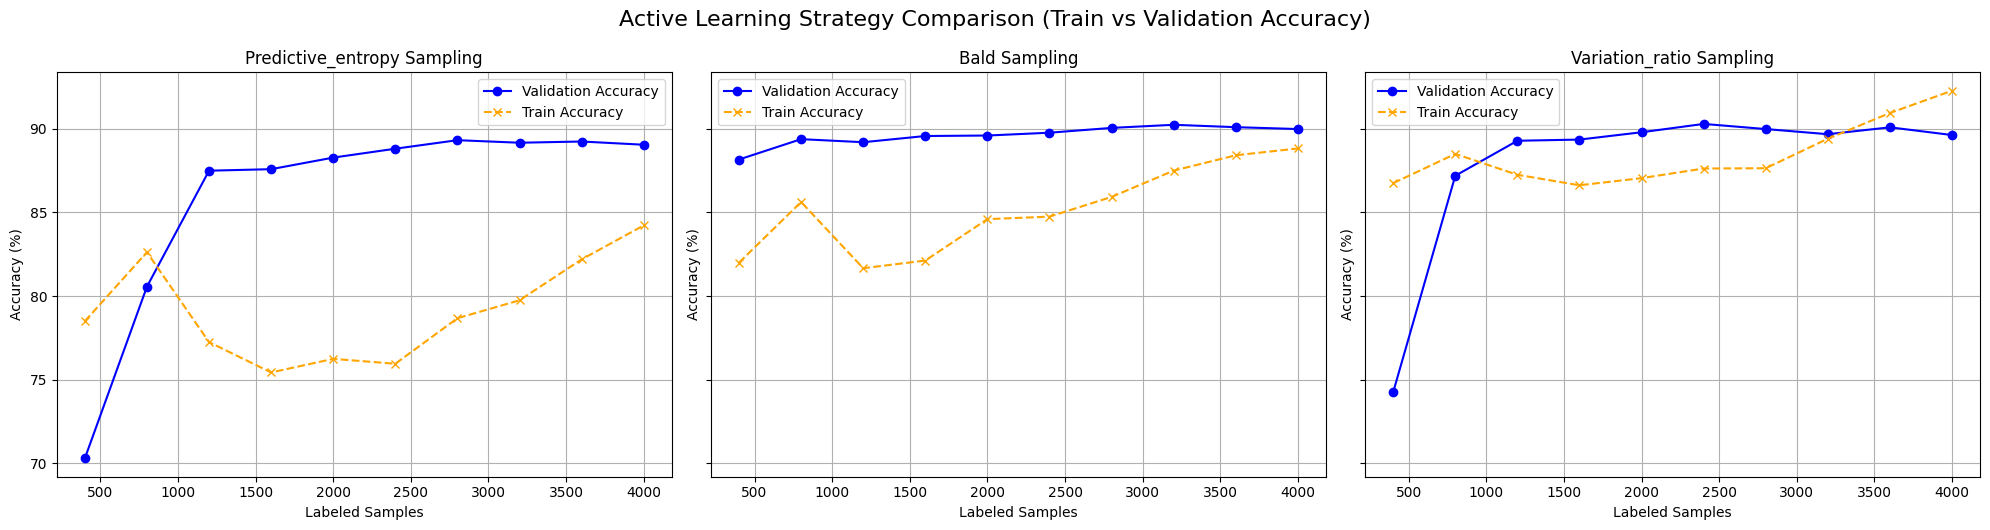

In [86]:
# Accuracy Plot: Train vs Val
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_accs = [a * 100 for a in history["val_accuracy"]]
    train_accs = [acc_list[-1] * 100 for acc_list in history["train_accuracy"]]  # last epoch of each round

    axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
    axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
plt.show()

<hr>